Shape of median matrix: (98, 13)


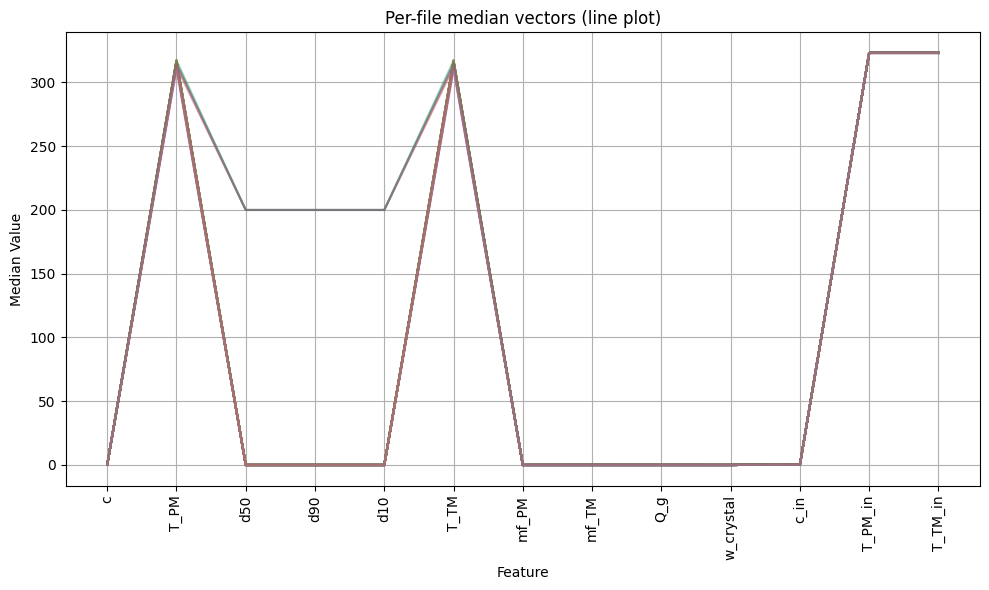

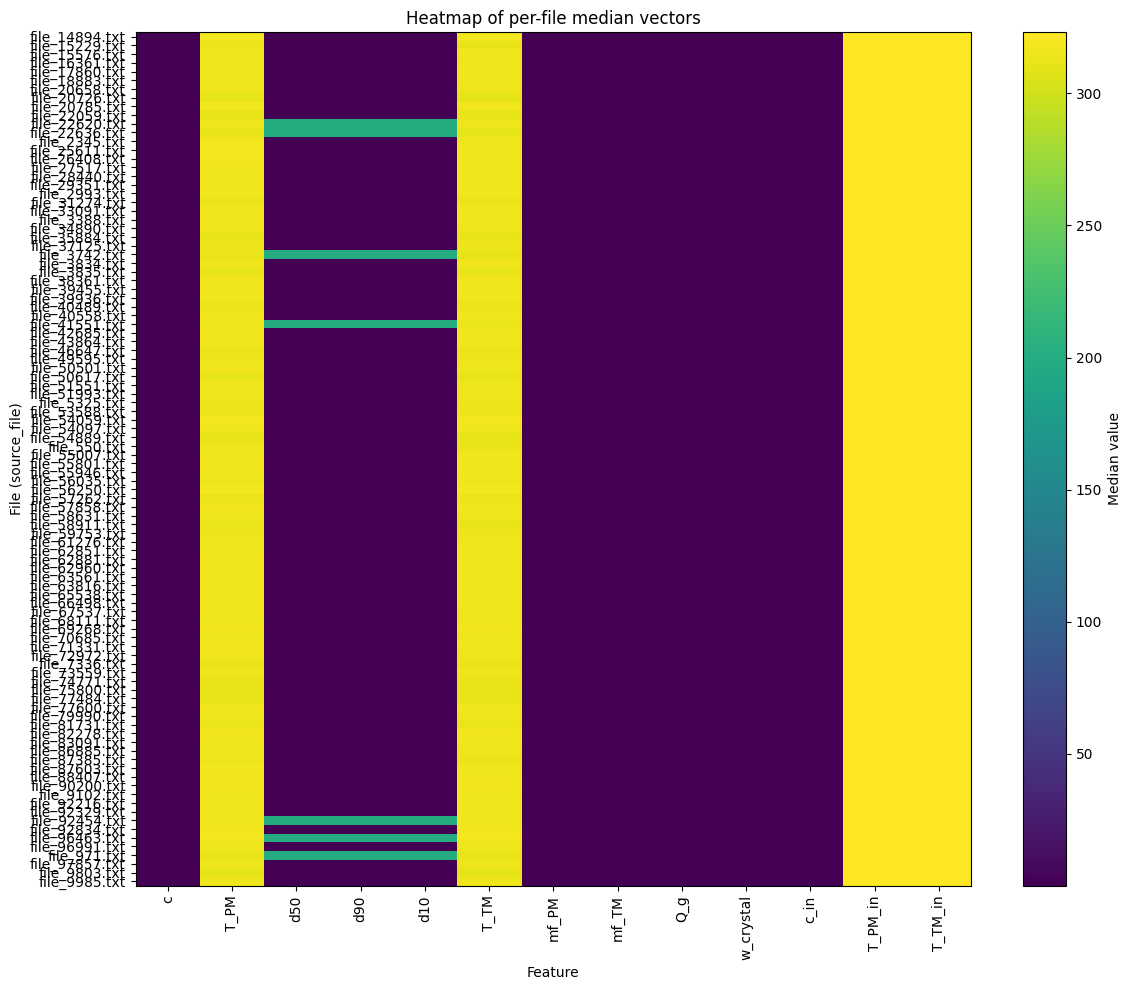

Files removed via IQR: ['file_22620.txt', 'file_22636.txt', 'file_3742.txt', 'file_41551.txt', 'file_92454.txt', 'file_96463.txt', 'file_971.txt', 'file_9803.txt']
Remaining files after IQR: 90
Files removed via DBSCAN: []
Remaining files after DBSCAN: 98


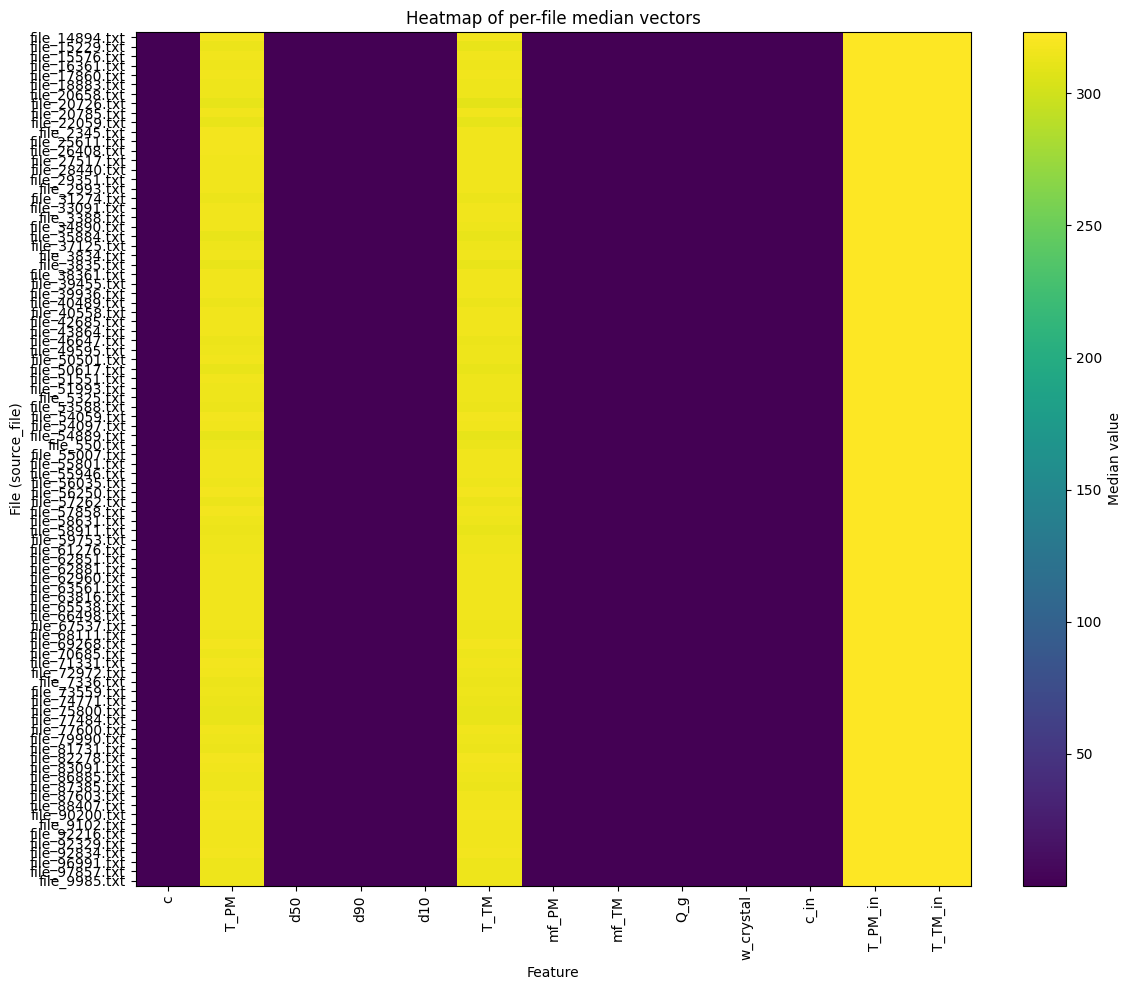

In [4]:
# %% [markdown]
# # CrysID-MLME25 Project Pipeline
# 
# This notebook:
# 
# 1. Loads all 98 TXT files
# 2. Computes per-file 13×1 median vectors
# 3. Visualizes those medians
# 4. Detects/removes noisy files based on d10/d50/d90

# %% [code]
from data_utils import load_txt_data
from analysis_utils import (
    compute_median_vectors,
    plot_median_vectors_line,
    plot_median_heatmap,
    filter_outliers_iqr,
    filter_outliers_dbscan
)

# %% [markdown]
# ## 1. Load all 98 TXT files

# %% [code]
# Update the path below to your actual data folder:
df = load_txt_data("data/raw")

# %% [markdown]
# ## 2. Compute per-file 13×1 median vectors

# %% [code]
medians_df = compute_median_vectors(df)
print("Shape of median matrix:", medians_df.shape)

# %% [markdown]
# ## 3. Visualize median vectors

# %% [code]
# Line plot version:
plot_median_vectors_line(medians_df)

# Heatmap version:
plot_median_heatmap(medians_df)

# %% [markdown]
# ## 4. Remove noisy files using d10, d50, d90

# %% [markdown]
# ### Option A - IQR method

# %% [code]
filtered_iqr, removed_iqr = filter_outliers_iqr(
    medians_df,
    cols=["d10", "d50", "d90"],
    k=1.5
)
print("Files removed via IQR:", removed_iqr)
print(f"Remaining files after IQR: {len(filtered_iqr)}")

# %% [markdown]
# ### Option B - DBSCAN method

# %% [code]
filtered_db, removed_db = filter_outliers_dbscan(
    medians_df,
    cols=["d10", "d50", "d90"],
    eps=0.05,     # adjust based on your data scale!
    min_samples=5
)
print("Files removed via DBSCAN:", removed_db)
print(f"Remaining files after DBSCAN: {len(filtered_db)}")

# %% [markdown]
# ## 5. Visualize cleaned median vectors

# %% [code]
# Example: show heatmap after IQR filtering
plot_median_heatmap(filtered_iqr)
# or:
# plot_median_heatmap(filtered_db)


Initial raw shape: (98000, 14)
After preprocessing: (98000, 9)


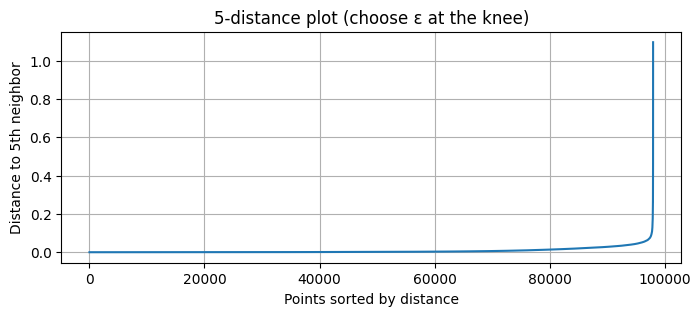

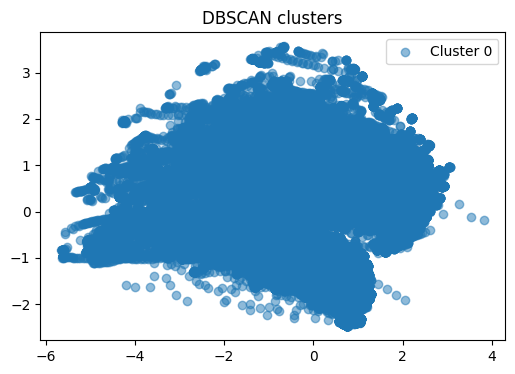

Train shape: (39200, 10)
Val shape:   (29400, 10)
Cal shape:   (14700, 10)
Test shape:  (14700, 10)


In [5]:
# ── Imports ──────────────────────────────────────────────────────────────
from data_utils import load_txt_data, plot_feature_distributions
from clustering import (
    split_data,
    prepare_cluster_input,
    plot_k_distance_curve,
    cluster_dbscan,
    plot_dbscan_clusters
)
from preprocessing import preprocess_features

# ── Load raw txt data ─────────────────────────────────────────────────────
# This loads all .txt files under your relative path
df = load_txt_data("data/raw")
print("Initial raw shape:", df.shape)

# ── Preprocess ────────────────────────────────────────────────────────────
df_clean, removed = preprocess_features(
    df,
    corr_threshold=0.95,
    consider_only_numeric=True
)
print("After preprocessing:", df_clean.shape)

# ── Cluster entire cleaned dataset ────────────────────────────────────────
X2d_full, _, _ = prepare_cluster_input(df_clean, use_pca=True, pca_components=2)
_ = plot_k_distance_curve(X2d_full, k=5)

# Pick ε and min_samples from your k-distance plot
eps_choice, min_samples = 2.0, 5

db_res = cluster_dbscan(
    df_clean,
    eps=eps_choice,
    min_samples=min_samples,
    use_pca=True,
    pca_components=2
)
df_clean["cluster"] = db_res["labels"]

plot_dbscan_clusters(db_res["cluster_input"], db_res["labels"])

# ── Split into Train / Val / Cal / Test ───────────────────────────────────
train_df, val_df, cal_df, test_df = split_data(df_clean)
print("Train shape:", train_df.shape)
print("Val shape:  ", val_df.shape)
print("Cal shape:  ", cal_df.shape)
print("Test shape: ", test_df.shape)


In [6]:
from modeling import grid_search_narx_pytorch

y_cols = ['T_PM','c','d10','d50','d90','T_TM']
u_cols = ['mf_PM','mf_TM','Q_g','w_crystal','c_in','T_PM_in','T_TM_in']
n_lags = 5

param_grid = {
    'module__hidden_sizes': [(50,50), (100,50), (100,100)],
    'optimizer__lr':        [1e-3, 1e-4],
    'max_epochs':           [500, 1000]
}

cluster_params = grid_search_narx_pytorch(
    train_df,
    cluster_col='cluster',
    y_cols=y_cols,
    u_cols=u_cols,
    n_lags=n_lags,
    param_grid=param_grid,
    cv_splits=3,
    device='cpu'
)

for cid, best in cluster_params.items():
    print(f"Cluster {cid}: {best}")


KeyError: "['d10', 'd90', 'T_TM', 'T_PM_in', 'T_TM_in'] not in index"